### How do models augmented with different types of data compare?

We compare the following models:

- M: not augmented
- M_CAD: augmented with manual CAD
- M_aCAD: augmented with automated CAD from polyjuice 
- M_aCAD_gpt: augmented with adversarial examples

What are the labels of the augmented data? For those where there is no ground truth, use heuristics

#### Usecases

Sexism and hate speech because the ude of identity terms there is especially noteworthy.

#### Datasets

- training:
- test: in-domain, out-of-domain, Hatecheck

#### Models

Logreg, DistilBERT

#### Metrics

F1, FPR, and others in https://arxiv.org/pdf/2203.09192.pdf

### Experimental Setup

- train 100 models of each type with different train-test splits, alwasy test on OOD and HC
- train 100 models, but keep the 'base' data in all different models consistent

### todo: 
- ~~model trained on CAD from all sources~~

In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# DESIGNEDDATAPATH = '../designed_data/cad/'

In [2]:
constructs = ['sexism']
construct_names = [
    'sexism',
    ]
perplexity = 10 # 1, 5, 10, 15, 20
runs = 1

reverse_label_encode = {'sexism' : {1 : 'sexist', 0 : 'non-sexist'},
                        'hatespeech' : {1 : 'hate', 0 : 'not hate'}
                       }
            
label_encode = {'hatespeech': {'hate' : 1, 'not hate': 0},
                    'sexism' : {'sexist' : 1, 'non-sexist': 0}
                   }

transformer = 'roberta'

transformer_base = {'distilbert': 'distilbert-base-uncased',
                'roberta': 'roberta-base'}

In [3]:
DESIGNEDDATAPATH = '../data/data/%s/train/paired_cads_mixed.csv' %construct_names[0]

In [4]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [5]:
classifiers = [
               # ('MNB', MultinomialNB),
               ('Linear SVM', LinearSVC),
               # ('LR', LogisticRegression),
               # ('RF', RandomForestClassifier),
               # ('transformer', 'transformer')
]

features = ['_TF-IDF', '_fasttext']

modes = {
         'OG' : ('original_text', 'original_label'),
         'CAD' : ('counterfactual_text', 'counterfactual_label'),
         # 'Adv_inv' : ('adv_inv', 'adv_inv_label'),
         # 'Adv_swap' : ('adv_swap', 'adv_swap_label'),
         'aCAD' : ('polyjuice', 'polyjuice_label'),
         # 'aCAD_R' : ('random_polyjuice', 'random_polyjuice_label'),
         'aCAD_GPT' : ('chatgpt', 'chatgpt_label'),
         'aCAD_FT' : ('flant5', 'flant5_label'),
         'CAD_mixed' : ('mixed_cad_text', 'mixed_cad_label'),   
    
}

In [6]:
# ! pip install pickle5

In [7]:
DESIGNEDDATAPATH = '../designed_data/cad/'

In [8]:
paired_data = {}

for construct in construct_names:
    # train_data_path = '../../socialCAD_/data/data/%s/train' %construct
    # paired_data[construct] = pd.read_csv(train_data_path + '/paired_adv_cad_GPT_%d.csv' %(perplexity), sep = '\t')
    train_data_path = '../data/data/%s/train/paired_cads_flant5.csv' %construct
    train_data_path = '../data/data/%s/train/paired_cads_mixed.csv' %construct
    paired_data[construct] = pd.read_csv(train_data_path, sep = '\t')#.head(100)
    paired_data[construct]['polyjuice_id'] = [str(i)+'p' for i in paired_data[construct]['original_id']]
    paired_data[construct]['chatgpt_id'] = [str(i)+'gpt' for i in paired_data[construct]['original_id']]
    paired_data[construct]['flant5_id'] = [str(i)+'ft' for i in paired_data[construct]['original_id']]
    paired_data[construct]['mixed_id'] = [str(i)+'m' for i in paired_data[construct]['original_id']]

In [9]:
paired_data[construct].columns

Index(['original_id', 'original_text', 'original_label', 'counterfactual_id',
       'counterfactual_text', 'counterfactual_label', 'diff', 'polyjuice',
       'polyjuice_label', 'negation_additions', 'negation_deletions',
       'affect word_additions', 'affect word_deletions',
       'gender word_additions', 'gender word_deletions',
       'identity word_additions', 'identity word_deletions',
       'hedges_additions', 'hedges_deletions', 'hate words_additions',
       'hate words_deletions', 'chatgpt', 'chatgpt_label', 'flant5',
       'flant5_label', 'polyjuice_text', 'chatgpt_text', 'flant5_text',
       'mixed_cad_text', 'mixed_cad_type', 'mixed_cad_label', 'polyjuice_id',
       'chatgpt_id', 'flant5_id', 'mixed_id'],
      dtype='object')

In [10]:
for construct in construct_names:
    print(construct)
    print(paired_data[construct].groupby('original_label').size())
    print()
    print(paired_data[construct].groupby('counterfactual_label').size())
    print()
    print(paired_data[construct].groupby('polyjuice_label').size())
    print()
    print(paired_data[construct].groupby('chatgpt_label').size())
    print()
    print(paired_data[construct].groupby('flant5_label').size())
    print()
    print(paired_data[construct].groupby('mixed_cad_label').size())
    print('---------------------------------------------------------')

sexism
original_label
non-sexist    1610
sexist        1244
dtype: int64

counterfactual_label
MAR            596
NMAR          1610
non-sexist     648
dtype: int64

polyjuice_label
MAR            553
NMAR          1610
non-sexist     691
dtype: int64

chatgpt_label
MAR              2
NMAR          1610
non-sexist    1242
dtype: int64

flant5_label
MAR            103
NMAR          1610
non-sexist    1141
dtype: int64

mixed_cad_label
MAR            317
NMAR          1610
non-sexist     927
dtype: int64
---------------------------------------------------------


In [11]:
paired_data[construct][['original_label', 'counterfactual_label', 'chatgpt_label', 'flant5_label', 'mixed_cad_label']]

,original_label,counterfactual_label,chatgpt_label,flant5_label,mixed_cad_label
0,sexist,non-sexist,non-sexist,non-sexist,MAR
1,non-sexist,NMAR,NMAR,NMAR,NMAR
2,sexist,non-sexist,non-sexist,non-sexist,non-sexist
3,non-sexist,NMAR,NMAR,NMAR,NMAR
4,non-sexist,NMAR,NMAR,NMAR,NMAR
...,...,...,...,...,...
2849,sexist,non-sexist,non-sexist,non-sexist,non-sexist
2850,non-sexist,NMAR,NMAR,NMAR,NMAR
2851,sexist,MAR,non-sexist,non-sexist,non-sexist
2852,sexist,non-sexist,non-sexist,non-sexist,non-sexist


In [12]:
paired_data[construct].isna().sum()

original_id                   0
original_text                 0
original_label                0
counterfactual_id          2206
counterfactual_text        2206
counterfactual_label          0
diff                       2206
polyjuice                  1312
polyjuice_label               0
negation_additions         2206
negation_deletions         2206
affect word_additions      2206
affect word_deletions      2206
gender word_additions      2206
gender word_deletions      2206
identity word_additions    2206
identity word_deletions    2206
hedges_additions           2206
hedges_deletions           2206
hate words_additions       2206
hate words_deletions       2206
chatgpt                       5
chatgpt_label                 0
flant5                      277
flant5_label                  0
polyjuice_text             1312
chatgpt_text                  5
flant5_text                 277
mixed_cad_text              952
mixed_cad_type                0
mixed_cad_label               0
polyjuic

In [13]:
text_cols = ['original_text', 'counterfactual_text', #'adv_inv', 'adv_swap',
             'polyjuice',
             # 'random_polyjuice'
             'chatgpt',
             'flant5',
             'mixed_cad_text',
            ]

In [14]:
# !pip install fasttext

In [15]:
import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

In [16]:
for construct in construct_names:
    for text_col in text_cols:
        feats = []
        for _, row in paired_data[construct].iterrows():
            if type(row[text_col]) == str:
                feats.append(ft.get_sentence_vector(row[text_col].replace('\n', ' ')))
            else:
                feats.append('')
        paired_data[construct][text_col + '_fasttext'] = feats

In [17]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
examples = paired_data[construct].copy()
examples = examples[~examples['counterfactual_text'].isna()]
examples = examples[~examples['polyjuice'].isna()]
examples = examples[~examples['flant5'].isna()]
examples = examples[~examples['flant5'].isna()]
examples[['original_text', 'original_label', 
       'counterfactual_text', 'polyjuice', 'chatgpt',
       'flant5']].head(8)

,original_text,original_label,counterfactual_text,polyjuice,chatgpt,flant5
10,I believe women were made to wear dresses,sexist,I believe women were made equal,And believe women were made to wear dresses,"I believe everyone should have the freedom to wear whatever they feel comfortable in, whether that be dresses or other clothing.",I believe women were made to wear skirts
19,I really dislike working with women in lab. Can I have my socially inept boys back?,sexist,I really dislike working with undergrads in lab. Can I have my socially inept grad students back?,I really dislike working with women in lab. Will I have my socially inept boys back?,"I really enjoy working with my male colleagues in lab, but I also appreciate the contributions of my female colleagues.",I really dislike working with women in lab. I can have my socially inept boys back.
34,RT @LewisHutchinson Mum plugs the ipad charger in but doesn't turn the plug on #typicalwoman #notsexist,sexist,RT @LewisHutchinson Mum plugs the ipad charger in but doesn't turn the plug on #typicaloldperson,RT @LewisHutchinson Mum plugs the ipad charger in but doesn't switch the plug on \#typicalwoman \#notsexist,Mum plugs in the iPad charger but forgets to turn it on. #typicalmistake #notsexist,RT @LewisHutchinson Mum plugs the ipad charger in but she doesn't turn the plug on #typicalwoman #notsexist
50,RT @SnackPrine Im not sexist but some females need to stay off the fucking roads,sexist,RT @SnackPrine some drivers need to stay off the fucking roads,RT @SnackPrine Im not sexist but some females need to stay at the fucking roads,Some people need to improve their driving skills.,RT @SnackPrine I'm not sexist but some females need to stay off the fucking roads
51,women can't drive. The only exception: danica patrick.,sexist,teenagers can't drive. The only exception: my kid.,the man can't drive. The only exception: danica patrick.,Only Danica Patrick can drive.,danica patrick.
52,women's cricket is boring.,sexist,cricket is boring.,mike's cricket is boring.,Cricket is boring.,women's cricket is exciting.
63,"whenever I see some idiot perform a dangerous, boneheaded driving maneuver, half the time it turns out to be a woman.",sexist,"whenever I see some idiot perform a dangerous, boneheaded driving maneuver, half the time it turns out to be an old person.","whenever I see a idiot perform a dangerous, boneheaded driving maneuver, half the time it turns out to be a woman.","Whenever I see someone perform a dangerous, boneheaded driving maneuver, it always catches my attention.","whenever I see some idiot perform an unsafe, boneheaded driving maneuver, half the time it turns out to be a woman."
66,I do not like female engineering teachers,sexist,I do not like engineering teachers,I do not like female managers teachers,I do not have a preference for female or male engineering teachers.,I like female engineering teachers


In [19]:
paired_data[construct].columns

Index(['original_id', 'original_text', 'original_label', 'counterfactual_id',
       'counterfactual_text', 'counterfactual_label', 'diff', 'polyjuice',
       'polyjuice_label', 'negation_additions', 'negation_deletions',
       'affect word_additions', 'affect word_deletions',
       'gender word_additions', 'gender word_deletions',
       'identity word_additions', 'identity word_deletions',
       'hedges_additions', 'hedges_deletions', 'hate words_additions',
       'hate words_deletions', 'chatgpt', 'chatgpt_label', 'flant5',
       'flant5_label', 'polyjuice_text', 'chatgpt_text', 'flant5_text',
       'mixed_cad_text', 'mixed_cad_type', 'mixed_cad_label', 'polyjuice_id',
       'chatgpt_id', 'flant5_id', 'mixed_id', 'original_text_fasttext',
       'counterfactual_text_fasttext', 'polyjuice_fasttext',
       'chatgpt_fasttext', 'flant5_fasttext', 'mixed_cad_text_fasttext'],
      dtype='object')

In [20]:
# do results change if i assume polyjuice flips the labels?

label_reverse = {'hate' : 'not hate', 'not hate' : 'hate', 'MAR' : 'MAR',
                 'sexist' : 'non-sexist', 'non-sexist' : 'sexist'}

# if flip_pj == '_aCAD_labelflip_random':
#     paired_data[construct]['polyjuice_label'] = [label_reverse[i] for i in paired_data[construct]['polyjuice_label'].values]
#     paired_data[construct]['random_polyjuice_label'] = [label_reverse[i] for i in paired_data[construct]['random_polyjuice_label'].values]
#     paired_data[construct]['mixed_cad_label'] = [label_reverse[row['mixed_cad_label']] if row['mixed_cad_type'] == 'polyjuice' else row['mixed_cad_label'] for _,
#                                                  row in paired_data[construct].iterrows()]

In [21]:
for construct in construct_names:
    print(construct)
    print(paired_data[construct].groupby('original_label').size())
    print()
    print(paired_data[construct].groupby('counterfactual_label').size())
    print()
    print(paired_data[construct].groupby('polyjuice_label').size())
    print()
    print(paired_data[construct].groupby('chatgpt_label').size())
    print()
    print(paired_data[construct].groupby('flant5_label').size())
    print()
    print(paired_data[construct].groupby('mixed_cad_label').size())
    print('---------------------------------------------------------')

sexism
original_label
non-sexist    1610
sexist        1244
dtype: int64

counterfactual_label
MAR           596 
NMAR          1610
non-sexist    648 
dtype: int64

polyjuice_label
MAR           553 
NMAR          1610
non-sexist    691 
dtype: int64

chatgpt_label
MAR           2   
NMAR          1610
non-sexist    1242
dtype: int64

flant5_label
MAR           103 
NMAR          1610
non-sexist    1141
dtype: int64

mixed_cad_label
MAR           317 
NMAR          1610
non-sexist    927 
dtype: int64
---------------------------------------------------------


In [22]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

def train_transformer(construct, mode, run = 0):
    # Optional model configuration
    model_args = ClassificationArgs()
    
    model_args.num_train_epochs=15
    model_args.output_dir = "models/%s_%s_%d_outputs/" %(construct, mode,run) 
    model_args.overwrite_output_dir=True
    model_args.use_multiprocessing=False
    model_args.use_multiprocessing_for_evaluation=False
    model_args.use_early_stopping = True
    model_args.early_stopping_delta = 0.01
    model_args.evaluate_during_training_verbose = True
    model_args.early_stopping_consider_epochs = True                                    
    model_args.eval_batch_size = 32
    model_args.learning_rate = 1e-6
    model_args.max_seq_length = 512
    model_args.early_stopping_min_delta = 0.01
    model_args.early_stopping_patience = 3
    model_args.evaluate_during_training = True
    model_args.evaluate_during_training_steps = 500
    model_args.evaluate_during_training_verbose = True
    model_args.save_eval_checkpoints = False
    model_args.save_model_every_epoch = False
    
       
    # Create a ClassificationModel
    model = ClassificationModel(
        # 'distilbert', 'distilbert-base-uncased', args=model_args, use_cuda = True
        # 'roberta', 'roberta-base', args=model_args, use_cuda = True
        # 'albert', 'albert-base-v2', args=model_args, use_cuda = True
        transformer, transformer_base[transformer], args=model_args, use_cuda = False
        
    )
    return model, model_args.output_dir

In [23]:
modes

{'OG': ('original_text', 'original_label'),
 'CAD': ('counterfactual_text', 'counterfactual_label'),
 'aCAD': ('polyjuice', 'polyjuice_label'),
 'aCAD_GPT': ('chatgpt', 'chatgpt_label'),
 'aCAD_FT': ('flant5', 'flant5_label'),
 'CAD_mixed': ('mixed_cad_text', 'mixed_cad_label')}

In [24]:
from sklearn.model_selection import train_test_split

def train_model(data_, construct = 'hatespeech',
                features = 'TF-IDF', classifier_type = LinearSVC,
                mode = 'OG', run = 0):
        
    data = data_.copy()
    # step 1. stratify and equalize classes (by original labels)
    g = data.groupby(modes['OG'][1])
    training_data = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
    print(len(training_data))
    if mode == 'OG':
        training_X = training_data[modes['OG'][0] + features].values
        training_y = training_data[modes['OG'][1]].values
        
        training_data_datamap = [training_data[modes['OG'][0].split('_')[0] + '_id'].values,
                                 training_data[modes['OG'][0]].values,
                                 training_data[modes['OG'][1]].values,
                                 ['original'] * len(training_data[modes['OG'][1]])
                                ]
    else:
        # step 2. keep pos class as is
        pos_data = training_data[training_data[modes['OG'][1]] == reverse_label_encode[construct][1]]
        training_X = list(pos_data[modes['OG'][0] + features].values) #adding the OGs
        training_y = list(pos_data[modes['OG'][1]].values)
            
        # Step 3: drop half of the negative data (non-sexist, non-hate)
        neg_data = training_data[training_data[modes['OG'][1]] == reverse_label_encode[construct][0]]
        neg_sample_len = len(neg_data)
        neg_data = neg_data.sample(n = neg_sample_len//2)
        training_X.extend(list(neg_data[modes['OG'][0] + features].values)) #adding the OGs
        training_y.extend(list(neg_data[modes['OG'][1]].values))
            
        # replace with that much counterfactual
        neg_cad_data = pos_data#.sample(n = neg_sample_len//2)
        # drop the missing CADs (MAR)
        neg_cad_data = neg_cad_data[neg_cad_data[modes[mode][1]] != 'MAR']
        neg_cad_data = neg_cad_data.sample(n = neg_sample_len//2)
        training_X.extend(list(neg_cad_data[modes[mode][0] + features].values)) #adding the CADs
        training_y.extend(list(neg_cad_data[modes[mode][1]].values))
            
        ids = list(pos_data[modes['OG'][0].split('_')[0] + '_id'].values)
        ids.extend(list(neg_data[modes['OG'][0].split('_')[0] + '_id'].values))
        ids.extend(list(neg_cad_data[modes[mode][0].split('_')[0] + '_id'].values))
        
        texts = list(pos_data[modes['OG'][0]].values)
        texts.extend(list(neg_data[modes['OG'][0]].values))
        texts.extend(list(neg_cad_data[modes[mode][0]].values))
        
        labels = list(pos_data[modes['OG'][1]].values)
        labels.extend(list(neg_data[modes['OG'][1]].values))
        labels.extend(list(neg_cad_data[modes[mode][1]].values))
        
        mode_lists = ['original'] * (len(pos_data) + len(neg_data))
        mode_lists.extend([modes[mode][1].split('_')[0]] * len(neg_cad_data))
        
        training_data_datamap = [ids, texts, labels, mode_lists]
        
    training_data_datamap_df = pd.DataFrame(training_data_datamap).T
    training_data_datamap_df.columns = ['id', 'text', 'label', 'data_type']
    print('FINAL DIST: ', training_data_datamap_df.groupby('label').size())
    
    train, dev = train_test_split(training_data_datamap_df, test_size = 0.2, stratify = training_data_datamap_df[['label',
                                                                                                                  'data_type']])
    # train.to_csv('../data/for_datamaps/train/%s_%s_%d.csv' %(construct, mode, run), index = False)
    # dev.to_csv('../data/for_datamaps/dev/%s_%s_%d.csv' %(construct, mode, run), index = False)
    
    if classifier_type == 'transformer':
        classifier, classifier_path = train_transformer(construct, mode, run)
        train_data = []
        for n, text in enumerate(training_X):
            train_data.append((text, label_encode[construct][training_y[n]]))
        train_df = pd.DataFrame(train_data)
        train_df.columns = ["text", "labels"]
        train_df, dev_df = train_test_split(train_df, test_size = 0.2, stratify = train_df[['labels']])
        
        classifier.train_model(train_df, eval_df = dev_df)
        return classifier_path
    else:
        training_X = np.array([list(i) for i in training_X])
        classifier = classifier_type()
        if classifier_type == LinearSVC:
            from sklearn.calibration import CalibratedClassifierCV
            from sklearn.pipeline import Pipeline
            from sklearn.model_selection import GridSearchCV
            from sklearn.preprocessing import StandardScaler

            SVCpipe = Pipeline([('scale', StandardScaler()),
                   ('SVC',LinearSVC())])

            # Gridsearch to determine the value of C
            param_grid = {'SVC__C':np.arange(0.01,100,10)}
            linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True)
            linearSVC.fit(training_X, training_y)
            
            bestlinearSVC = linearSVC.best_estimator_
            print(bestlinearSVC)
            classifier = CalibratedClassifierCV(bestlinearSVC)  
        classifier.fit(training_X, training_y)
    
        return classifier

In [25]:
model = {'construct': '',
          'data_size': 1000,
          'features' : '_fasttext',
          'classifier_name' : 'Linear SVM',
          'run' : 0,
          'mode' : 'OG'
         }


all_models = []

for construct in constructs:
    model = {}
    model['construct'] = construct
    for mode in modes:
        print(mode)
        model['mode'] = mode
        for feature in ['_fasttext']:
            model['feature'] = feature
            for classifier_name, classifier_type in classifiers:
                model['classifier_name'] = classifier_name
                for run in range(runs):
                    model['run'] = run
                    if classifier_type == 'transformer':
                            model['feature'] = ''
                        
                    model['classifier'] = train_model(paired_data[construct], construct,
                                                      features = model['feature'], classifier_type = classifier_type,
                                                      mode = mode, run = run)
                    all_models.append(model.copy())


OG
2488
FINAL DIST:  label
non-sexist    1244
sexist        1244
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

Pipeline(steps=[('scale', StandardScaler()), ('SVC', LinearSVC(C=0.01))])
CAD
2488
FINAL DIST:  label
non-sexist    1244
sexist        1244
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

Pipeline(steps=[('scale', StandardScaler()), ('SVC', LinearSVC(C=0.01))])
aCAD
2488
FINAL DIST:  label
non-sexist    1244
sexist        1244
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

Pipeline(steps=[('scale', StandardScaler()), ('SVC', LinearSVC(C=0.01))])
aCAD_GPT
2488
FINAL DIST:  label
non-sexist    1244
sexist        1244
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

Pipeline(steps=[('scale', StandardScaler()), ('SVC', LinearSVC(C=0.01))])
aCAD_FT
2488
FINAL DIST:  label
non-sexist    1244
sexist        1244
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

Pipeline(steps=[('scale', StandardScaler()), ('SVC', LinearSVC(C=0.01))])
CAD_mixed
2488
FINAL DIST:  label
non-sexist    1244
sexist        1244
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

Pipeline(steps=[('scale', StandardScaler()), ('SVC', LinearSVC(C=0.01))])


In [26]:
pd.DataFrame(all_models)

,construct,mode,feature,classifier_name,run,classifier
0,sexism,OG,_fasttext,Linear SVM,0,"CalibratedClassifierCV(base_estimator=Pipeline(steps=[('scale',\n StandardScaler()),\n ('SVC',\n LinearSVC(C=0.01))]))"
1,sexism,CAD,_fasttext,Linear SVM,0,"CalibratedClassifierCV(base_estimator=Pipeline(steps=[('scale',\n StandardScaler()),\n ('SVC',\n LinearSVC(C=0.01))]))"
2,sexism,aCAD,_fasttext,Linear SVM,0,"CalibratedClassifierCV(base_estimator=Pipeline(steps=[('scale',\n StandardScaler()),\n ('SVC',\n LinearSVC(C=0.01))]))"
3,sexism,aCAD_GPT,_fasttext,Linear SVM,0,"CalibratedClassifierCV(base_estimator=Pipeline(steps=[('scale',\n StandardScaler()),\n ('SVC',\n LinearSVC(C=0.01))]))"
4,sexism,aCAD_FT,_fasttext,Linear SVM,0,"CalibratedClassifierCV(base_estimator=Pipeline(steps=[('scale',\n StandardScaler()),\n ('SVC',\n LinearSVC(C=0.01))]))"
5,sexism,CAD_mixed,_fasttext,Linear SVM,0,"CalibratedClassifierCV(base_estimator=Pipeline(steps=[('scale',\n StandardScaler()),\n ('SVC',\n LinearSVC(C=0.01))]))"


## TODO: move all these to a standard preprocessing script
### get more ood datasets for sexism: 

- ID: Samory 
- OOD1: Hateval
- OOD2: Guest
- OOD3: Kirk
- OOD4: ??
- HC: Hatecheck

In [27]:
# ood2 = pd.read_csv('../data/data/sexism/test/online-misogyny-eacl2021/data/final_labels.csv')
# #ood2 = ood2[[]]#.groupby('level_1').size()
# ood2.groupby('level_1').size()

In [28]:
# ood2['_id'] = [row['entry_id'] + '_' + str(n) for n, row in ood2.iterrows()]
# len(ood2['_id'].unique())

In [29]:
# ood2 = ood2[['_id', 'body', 'level_1']]
# ood2.columns = ['_id', 'text', 'sexism']
# ood2['sexism'] = ['sexist' if i == 'Misogynistic' else 'non-sexist' for i in ood2['sexism']]
# ood2

In [30]:
# ood2 = ood2.dropna(subset = ['text'])

In [31]:
# ood2.groupby('sexism').size()

In [32]:
# ood2.to_csv('../data/data/sexism/test/out_of_domain_2.csv', sep = '\t', index = False)

In [33]:
# ood3 = pd.read_csv('../data/data/sexism/test/edos/data/edos_labelled_aggregated.csv')
# len(ood3), len(ood3['rewire_id'].unique())

In [34]:
# ood3.groupby('label_sexist').size()

In [35]:
# ood3 = ood3[['rewire_id', 'text', 'label_sexist']]
# ood3.columns = ['_id', 'text', 'sexism']
# ood3['sexism'] = ['non-sexist' if i == 'not sexist' else i for i in ood3['sexism']]
# ood3

In [36]:
# ood3.groupby('sexism').size()

In [37]:
# ood2.isna().sum()

In [38]:
# ood3.to_csv('../data/data/sexism/test/out_of_domain_3.csv', sep = '\t', index = False)

In [39]:
test_sets = ['in_domain', 'out_of_domain', 
             'out_of_domain_2', 'out_of_domain_3', 
             #'out_of_domain_4', 
             'hatecheck']

In [40]:
test_set_data = {}

for construct in construct_names:
    test_set_data[construct] = {}
    for test_set in test_sets:
        test_path = '../data/data/%s/test/%s.csv' %(construct, test_set)
        test_set_data[construct][test_set] = pd.read_csv(test_path, sep = '\t')
        test_set_data[construct][test_set]['text_fasttext'] = [ft.get_sentence_vector(row['text'].replace('\n',
                                                                                                          ' ')) for _,
                                                               row in test_set_data[construct][test_set].iterrows()]

In [41]:
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, roc_auc_score, f1_score, accuracy_score, recall_score
from sklearn import metrics

In [42]:
all_results = []

for model in all_models:
    result = model.copy()
    for test_set in test_sets:
        result['test_set'] = test_set
        test_data = test_set_data[model['construct']][test_set]
        construct = model['construct']
        
        if model['classifier_name'] == 'transformer':
            test_features = list(test_data['text'].values)
            classifier = ClassificationModel(transformer, model['classifier'])
            preds, raw_outputs = classifier.predict(test_features)
            from scipy.special import softmax

            probabilities = [i[0] for i in softmax(raw_outputs, axis=1).tolist()]
            preds = [reverse_label_encode[construct][i] for i in preds]
        else:
            test_features = np.array([list(i) for i in test_data['text_fasttext'].values])
            preds = model['classifier'].predict(test_features)
            probabilities = [i[0] for i in model['classifier'].predict_proba(test_features)]
        
        scores = precision_recall_fscore_support(test_set_data[construct][test_set][construct].values, preds)
        test_data['%s_%s_%d_predictions' %(model['mode'], model['classifier_name'],
                                              model['run'])] = preds
        test_data['%s_%s_%d_probabilities' %(model['mode'], model['classifier_name'],
                                              model['run'])] = probabilities
        
        result['predictions'] = preds
        result['pos_precision'] = scores[0][0]
        result['neg_precision'] = scores[0][1]
        result['pos_recall'] = scores[1][0]
        result['neg_recall'] = scores[1][0]
        result['pos_f1'] = scores[2][0]
        result['neg_f1'] = scores[2][1]
        result['macro_f1'] = f1_score(test_set_data[construct][test_set][construct].values, preds, average = 'macro')
        result['micro_f1'] = f1_score(test_set_data[construct][test_set][construct].values, preds, average = 'micro')
        
        fpr, tpr, thresholds = metrics.roc_curve(test_set_data[construct][test_set][construct].values,
                                                 probabilities, pos_label='sexist')
        result['auc'] = metrics.auc(fpr, tpr)
        result['auc'] = roc_auc_score(test_set_data[construct][test_set][construct].values,
                                                 probabilities)
        
        ## ref: https://stackoverflow.com/questions/56203875/how-to-compute-false-positive-rate-fpr-and-false-negative-rate-percantage
        tpr = recall_score(test_set_data[construct][test_set][construct].values,
                                                 preds, pos_label='sexist')
        tnr = recall_score(test_set_data[construct][test_set][construct].values,
                                                 preds, pos_label='non-sexist') 
        fpr = 1 - tnr
        fnr = 1 - tpr
        
        result['fpr'] = fpr
        
        all_results.append(result.copy())

In [43]:
for test_set in test_sets:
    print(test_set)
    print(test_set_data[model['construct']][test_set].columns)
    test_set_data[model['construct']][test_set] = test_set_data[model['construct']][test_set].drop('text_fasttext',
                                                                                                   axis=1)
    print()
    
# with open('results/intermediate/sexism_%s_results.pickle' %(transformer), 'wb') as handle:
#     pickle.dump(test_set_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

in_domain
Index(['_id', 'text', 'sexism', 'text_fasttext', 'OG_Linear SVM_0_predictions',
       'OG_Linear SVM_0_probabilities', 'CAD_Linear SVM_0_predictions',
       'CAD_Linear SVM_0_probabilities', 'aCAD_Linear SVM_0_predictions',
       'aCAD_Linear SVM_0_probabilities', 'aCAD_GPT_Linear SVM_0_predictions',
       'aCAD_GPT_Linear SVM_0_probabilities',
       'aCAD_FT_Linear SVM_0_predictions',
       'aCAD_FT_Linear SVM_0_probabilities',
       'CAD_mixed_Linear SVM_0_predictions',
       'CAD_mixed_Linear SVM_0_probabilities'],
      dtype='object')

out_of_domain
Index(['_id', 'text', 'sexism', 'text_fasttext', 'OG_Linear SVM_0_predictions',
       'OG_Linear SVM_0_probabilities', 'CAD_Linear SVM_0_predictions',
       'CAD_Linear SVM_0_probabilities', 'aCAD_Linear SVM_0_predictions',
       'aCAD_Linear SVM_0_probabilities', 'aCAD_GPT_Linear SVM_0_predictions',
       'aCAD_GPT_Linear SVM_0_probabilities',
       'aCAD_FT_Linear SVM_0_predictions',
       'aCAD_FT_Linear SVM_

In [44]:
all_results_df = pd.DataFrame(all_results)
# all_results_df = all_results_df[all_results_df['data_size'] == len(paired_data[construct])]
# all_results_df = all_results_df[all_results_df['classifier_name'] == 'transformer']
all_results_df = all_results_df[all_results_df['classifier_name'] == 'Linear SVM']
all_results_df.groupby(['construct', 'mode', 'test_set']).mean()[['macro_f1', 'micro_f1']]

macro_f1  micro_f1
construct mode      test_set                           
sexism    CAD       hatecheck        0.473148  0.524558
                    in_domain        0.743572  0.745915
                    out_of_domain    0.599551  0.616123
                    out_of_domain_2  0.524866  0.751182
                    out_of_domain_3  0.576489  0.658350
          CAD_mixed hatecheck        0.480443  0.508841
                    in_domain        0.722710  0.724673
                    out_of_domain    0.580371  0.596042
                    out_of_domain_2  0.507962  0.744928
                    out_of_domain_3  0.554891  0.648300
          OG        hatecheck        0.504521  0.536346
                    in_domain        0.755622  0.757353
                    out_of_domain    0.549110  0.576834
                    out_of_domain_2  0.512735  0.730587
                    out_of_domain_3  0.566853  0.666900
          aCAD      hatecheck        0.474139  0.500982
                    in_domain        0.650974  0.651144
                    out_of_domain    0.585159  0.585274
                    out_of_domain_2  0.465076  0.589626
                    out_of_domain_3  0.500337  0.541250
          aCAD_FT   hatecheck        0.498754  0.530452
                    in_domain        0.677174  0.677288
                    out_of_domain    0.536644  0.536671
                    out_of_domain_2  0.453097  0.558963
                    out_of_domain_3  0.490776  0.530500
          aCAD_GPT  hatecheck        0.519272  0.563851
                    in_domain        0.734952  0.735294
                    out_of_domain    0.590623  0.596624
                    out_of_domain_2  0.507014  0.696415
                    out_of_domain_3  0.545998  0.601900

In [45]:
all_results_df.groupby(['construct', 'mode', 'test_set']).std()[['macro_f1', 'micro_f1']]

macro_f1  micro_f1
construct mode      test_set                           
sexism    CAD       hatecheck       NaN       NaN      
                    in_domain       NaN       NaN      
                    out_of_domain   NaN       NaN      
                    out_of_domain_2 NaN       NaN      
                    out_of_domain_3 NaN       NaN      
          CAD_mixed hatecheck       NaN       NaN      
                    in_domain       NaN       NaN      
                    out_of_domain   NaN       NaN      
                    out_of_domain_2 NaN       NaN      
                    out_of_domain_3 NaN       NaN      
          OG        hatecheck       NaN       NaN      
                    in_domain       NaN       NaN      
                    out_of_domain   NaN       NaN      
                    out_of_domain_2 NaN       NaN      
                    out_of_domain_3 NaN       NaN      
          aCAD      hatecheck       NaN       NaN      
                    in_domain       NaN       NaN      
                    out_of_domain   NaN       NaN      
                    out_of_domain_2 NaN       NaN      
                    out_of_domain_3 NaN       NaN      
          aCAD_FT   hatecheck       NaN       NaN      
                    in_domain       NaN       NaN      
                    out_of_domain   NaN       NaN      
                    out_of_domain_2 NaN       NaN      
                    out_of_domain_3 NaN       NaN      
          aCAD_GPT  hatecheck       NaN       NaN      
                    in_domain       NaN       NaN      
                    out_of_domain   NaN       NaN      
                    out_of_domain_2 NaN       NaN      
                    out_of_domain_3 NaN       NaN

In [46]:
data = all_results_df.groupby(['construct', 'mode', 'test_set']).mean()[[                   'macro_f1',
                                                                               'micro_f1']].round(3)

std = all_results_df.groupby(['construct', 'mode', 'test_set']).std()[[                   'macro_f1',
                                                                             'micro_f1']].round(3)

In [47]:
for col in std.columns:
    std[col] = ' ± ' + std[col].astype(str)

INFO:numexpr.utils:Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [48]:
len(paired_data[construct]), runs

(2854, 1)

In [49]:
data = data.astype(str) + std.astype(str)
data

macro_f1     micro_f1
construct mode      test_set                                 
sexism    CAD       hatecheck        0.473 ± nan  0.525 ± nan
                    in_domain        0.744 ± nan  0.746 ± nan
                    out_of_domain    0.6 ± nan    0.616 ± nan
                    out_of_domain_2  0.525 ± nan  0.751 ± nan
                    out_of_domain_3  0.576 ± nan  0.658 ± nan
          CAD_mixed hatecheck        0.48 ± nan   0.509 ± nan
                    in_domain        0.723 ± nan  0.725 ± nan
                    out_of_domain    0.58 ± nan   0.596 ± nan
                    out_of_domain_2  0.508 ± nan  0.745 ± nan
                    out_of_domain_3  0.555 ± nan  0.648 ± nan
          OG        hatecheck        0.505 ± nan  0.536 ± nan
                    in_domain        0.756 ± nan  0.757 ± nan
                    out_of_domain    0.549 ± nan  0.577 ± nan
                    out_of_domain_2  0.513 ± nan  0.731 ± nan
                    out_of_domain_3  0.567 ± nan  0.667 ± nan
          aCAD      hatecheck        0.474 ± nan  0.501 ± nan
                    in_domain        0.651 ± nan  0.651 ± nan
                    out_of_domain    0.585 ± nan  0.585 ± nan
                    out_of_domain_2  0.465 ± nan  0.59 ± nan 
                    out_of_domain_3  0.5 ± nan    0.541 ± nan
          aCAD_FT   hatecheck        0.499 ± nan  0.53 ± nan 
                    in_domain        0.677 ± nan  0.677 ± nan
                    out_of_domain    0.537 ± nan  0.537 ± nan
                    out_of_domain_2  0.453 ± nan  0.559 ± nan
                    out_of_domain_3  0.491 ± nan  0.53 ± nan 
          aCAD_GPT  hatecheck        0.519 ± nan  0.564 ± nan
                    in_domain        0.735 ± nan  0.735 ± nan
                    out_of_domain    0.591 ± nan  0.597 ± nan
                    out_of_domain_2  0.507 ± nan  0.696 ± nan
                    out_of_domain_3  0.546 ± nan  0.602 ± nan

In [50]:
print(data.to_latex()) 

\begin{tabular}{lllll}
\toprule
       &          &                 &     macro\_f1 &     micro\_f1 \\
construct & mode & test\_set &              &              \\
\midrule
sexism & CAD & hatecheck &  0.473 ± nan &  0.525 ± nan \\
       &          & in\_domain &  0.744 ± nan &  0.746 ± nan \\
       &          & out\_of\_domain &  0.6 ± nan &  0.616 ± nan \\
       &          & out\_of\_domain\_2 &  0.525 ± nan &  0.751 ± nan \\
       &          & out\_of\_domain\_3 &  0.576 ± nan &  0.658 ± nan \\
       & CAD\_mixed & hatecheck &  0.48 ± nan &  0.509 ± nan \\
       &          & in\_domain &  0.723 ± nan &  0.725 ± nan \\
       &          & out\_of\_domain &  0.58 ± nan &  0.596 ± nan \\
       &          & out\_of\_domain\_2 &  0.508 ± nan &  0.745 ± nan \\
       &          & out\_of\_domain\_3 &  0.555 ± nan &  0.648 ± nan \\
       & OG & hatecheck &  0.505 ± nan &  0.536 ± nan \\
       &          & in\_domain &  0.756 ± nan &  0.757 ± nan \\
       &          & out\_of\_dom

In [51]:
# data.to_csv('../results/tables/initial_shallow_models_HS%s_%d_%d_%d.csv' %(flip_pj, perplexity,
#                                                                            len(paired_data[construct]), runs),
#             index = 'False', sep = '\t')

In [52]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', -1)

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [53]:
paired_data[construct].head(20)[['original_text', 'counterfactual_text', 'polyjuice']]

,original_text,counterfactual_text,polyjuice
0,Hayi fuck it nyaniRT @ClixWell: Women's 7s rugby? fuck this shit.,Hayi fuck it nyaniRT @ClixWell: Minor League 7s rugby? fuck this shit.,NaN
1,@Spacekatgal the client/web experience being similar are key. i don't know if twitter client has the additional controls verified accts have,NaN,NaN
2,when my man is hungry I'm making him the best damn sandwich he's ever tasted,when my child is hungry I'm making him the best damn sandwich he's ever tasted,NaN
3,"“There is no limit to what we, as women, can accomplish.” —Michelle Obama. Happy #WomensDay ! https://t.co/PRg9ozxg7S",NaN,NaN
4,.@ainsleyearhardt you looked beautiful in the deep blue/purple dress you wore today. What a knock out. Found your color?,NaN,.@ainsleyearhardt you looked fabulous in the deep blue/purple dress you wore today. What a knock out. Found your color?
5,she made a gif of a black street fighter player as a monkey. she started getting heat for it #GamerGate http://t.co/Dq73IwjrGf,NaN,she made a gif of a black street fighter player as a monkey. she started on heat for it \#GamerGate http://t.co/Dq73IwjrGf
6,It is obviously more logical that a state family allowance be paid to the father than to the mother,NaN,NaN
7,You lost me! I can't stand watching those conceited idiots any more! #MKR,NaN,You lost me! I can't stand watching those conceited idiots any less! \#MKR
8,A husband has the right to expect that his wife be obliging and dutiful at all times,NaN,NaN
9,Women think less clearly than men and are more emotional,NaN,Women think more clearly than men and are more emotional


In [54]:
paired_data[construct].sample(10)

,original_id,original_text,original_label,counterfactual_id,counterfactual_text,counterfactual_label,diff,polyjuice,polyjuice_label,negation_additions,negation_deletions,affect word_additions,affect word_deletions,gender word_additions,gender word_deletions,identity word_additions,identity word_deletions,hedges_additions,hedges_deletions,hate words_additions,hate words_deletions,chatgpt,chatgpt_label,flant5,flant5_label,polyjuice_text,chatgpt_text,flant5_text,mixed_cad_text,mixed_cad_type,mixed_cad_label,polyjuice_id,chatgpt_id,flant5_id,mixed_id,original_text_fasttext,counterfactual_text_fasttext,polyjuice_fasttext,chatgpt_fasttext,flant5_fasttext,mixed_cad_text_fasttext
1720,5d654927ce2c6bd7334796a5,I cannot listen to a woman call a men's football game.,sexist,5dc312dea72a9d5d0db94214,I cannot listen to a rookie call a professional football game.,non-sexist,"{'additions': ['rookie', 'professional'], 'deletions': ['woman', 'mens']}",I cannot listen to a woman call a men's football well.,non-sexist,False,False,False,False,False,True,False,False,False,False,False,False,I cannot listen to anyone call a men's football game.,non-sexist,I can not listen to a woman call a men's football game.,non-sexist,I cannot listen to a woman call a men's football well.,I cannot listen to anyone call a men's football game.,I can not listen to a woman call a men's football game.,I cannot listen to anyone call a men's football game.,chatgpt,non-sexist,5d654927ce2c6bd7334796a5p,5d654927ce2c6bd7334796a5gpt,5d654927ce2c6bd7334796a5ft,5d654927ce2c6bd7334796a5m,"[0.015342035, -0.016246144, -2.9824337e-06, 0.02968165, -0.039334554, -0.010142985, 0.008719362, 0.0021962528, 0.008802863, -0.007520775, 0.004824085, -0.01929792, -0.005050914, -0.01081176, -0.022825787, 0.07142275, 0.017001806, 0.003465717, -0.025121871, 0.05058611, -0.008477222, 0.011575107, 0.0003777065, -0.0041934843, -0.03260981, -0.00885694, -0.028306864, -0.0016146138, -0.009045928, 0.109911345, -0.015562578, -0.013543238, 0.015290995, -0.014123909, 0.02171281, -0.019332329, -0.022822833, -0.0018450036, -0.013933059, -0.02864474, -0.017320381, 0.025423324, -0.0055732154, 0.017290732, 0.007872032, 0.04305167, 0.023495965, 0.027172934, -0.04652103, 0.0063015134, 0.0074681058, -0.01752272, 0.0044613522, -0.013669695, -0.004639394, 0.0033276211, 0.0197661, -0.01548612, -0.067814164, -0.020708004, 0.031777635, -0.009903731, 5.153601e-06, -0.04131423, -0.015936669, -0.014159597, 0.011362713, 0.010614305, 0.0052582086, -0.02148721, -0.040439893, -0.0067205555, 0.0012744787, -0.02289195, -0.027110973, -0.012113669, 0.018624386, 0.012560686, -0.010510425, -0.0039725867, -0.02307867, -0.0042949915, 0.0042176424, 0.033473026, 0.044143822, -0.019024223, 0.0024071597, 0.031758204, 0.03247133, -0.017573621, -0.031868063, -0.023440043, 0.04822466, -0.006504285, -0.014330345, -0.004133083, -0.02089122, 0.016759008, -0.0011572093, 0.00838643, ...]","[0.0019922447, -0.01547284, -0.008640662, 0.034904566, -0.049943324, -0.010434406, 0.030422369, -0.012867283, -0.001860841, -0.016519142, -0.007180162, -0.0044373265, -0.018238809, 0.0024869367, -0.014926651, 0.062450718, 0.02889177, -0.011537656, -0.036007393, 0.056282073, -0.015777843, 0.0018072271, -0.0046072183, -0.0082768565, -0.029215857, -0.020363012, -0.022920214, 0.0033586007, -0.002536846, 0.09844059, -0.02032563, -0.037233315, 0.0058605997, -0.0038995645, 0.024469262, -0.016723027, -0.017382337, -0.0034255995, -0.0019319891, -0.02760635, -0.02425339, 0.014851649, -0.0038390453, 0.031708334, -0.0030649877, 0.03440383, 0.015203456, 0.018763963, -0.036633916, 0.0070689986, 0.009928366, 0.0034183543, 0.0025848392, -0.02720869, -0.000158637, 0.009405004, 0.0109961135, -0.01203215, -0.066762306, -0.019505512, 0.020572335, 0.0038151864, -0.014030793, -0.039180752, -0.021018896, -0.007352042, -0.0012466572, 0.015599666, 0.019133167, -0.021825997, -0.045993697, 0.0056111105, 0.018205952, -0.018667726, -0.019743236, -0.0017763085, 0.008338606, 0.012533398, 

In [55]:
# # for datamaps
# test_set_data = {}

# label_encode = {'hatespeech': {'hate' : 1, 'not hate': 0},
#                     'sexism' : {'sexist' : 1, 'non-sexist': 0}
#                    }

# for construct in construct_names:
#     test_set_data[construct] = {}
#     for test_set in test_sets:
#         test_path = '../../socialCAD_/data/data/%s/test/%s.csv' %(construct, test_set)
#         test_set_data[construct][test_set] = pd.read_csv(test_path, sep = '\t')
#         # print(test_set_data[construct][test_set].columns)
        
#         test_df = test_set_data[construct][test_set].copy()
#         test_df.columns = ['_id', 'text', 'label']
#         test_df['data_type'] = ['original'] * len(test_df)
#         test_df['label'] = [label_encode[construct][row['label']] for _, row in test_df.iterrows()]
#         # print(test_df)
#         # test_df.to_csv('../data/for_datamaps/test/%s_%s.csv' %(construct, test_set), index = False)
    

In [56]:
from os import listdir
from os.path import isfile, join

mypath = '../data/for_datamaps/test/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles

['hatespeech_out_of_domain_4.csv',
 'hatespeech_all_merged.csv',
 'hatespeech_hatecheck.csv',
 'hatespeech_out_of_domain.csv',
 'hatespeech_out_of_domain_2.csv',
 'hatespeech_out_of_domain_3.csv',
 'hatespeech_in_domain.csv']

In [57]:
import pandas as pd

dfs = []

for filename in onlyfiles:
    dfs.append(pd.read_csv(mypath + filename))
    dfs[-1]['source'] = [filename] * len(dfs[-1])
    
# pd.concat(dfs).to_csv(mypath + 'hatespeech_all_merged.csv', index = False)

In [58]:
constructs

['sexism']

In [59]:
all_results_df.columns

Index(['construct', 'mode', 'feature', 'classifier_name', 'run', 'classifier', 'test_set', 'predictions', 'pos_precision', 'neg_precision', 'pos_recall', 'neg_recall', 'pos_f1', 'neg_f1', 'macro_f1', 'micro_f1', 'auc', 'fpr'], dtype='object')

In [60]:
label_map = {'in_domain' : 'ID', 'out_of_domain' : 'OOD',
             'out_of_domain_2' : 'OOD2', 'out_of_domain_3' : 'OOD3',
             # 'out_of_domain_4' : 'OOD4', 
             'hatecheck' : 'HC'}

In [61]:
all_results_df['test_set'] = [label_map[i] for i in all_results_df['test_set']]

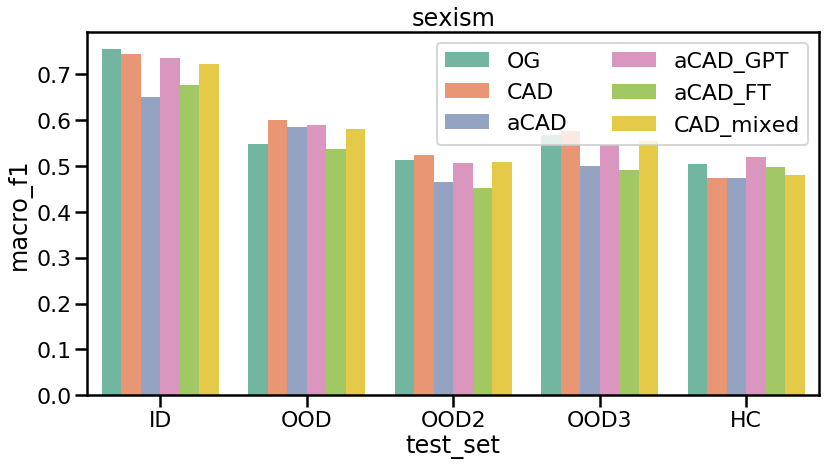

In [62]:
import seaborn as sns
import matplotlib as mpl 

sns.set_context('poster')

fig, ax = plt.subplots(figsize = (12, 7))
sns.barplot(data = all_results_df, x = 'test_set', y = 'macro_f1', #join = False,
             hue = 'mode', palette="Set2", # markers = True,#, hue_norm=mpl.colors.LogNorm()
            ax = ax)
title = construct
ax.set_title(title)
plt.legend(ncol=2)
plt.savefig('../results/figures/svm_%s.pdf' %title)
plt.tight_layout()
plt.show()

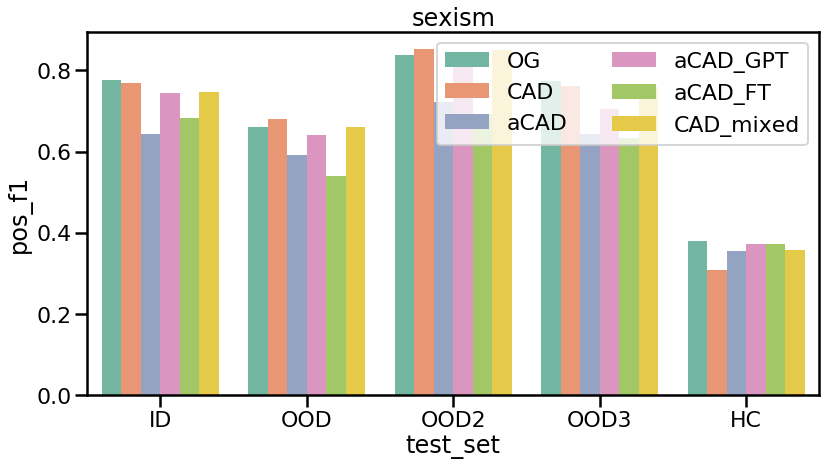

In [63]:
fig, ax = plt.subplots(figsize = (12, 7))
sns.barplot(data = all_results_df, x = 'test_set', y = 'pos_f1', #join = False,
             hue = 'mode', palette="Set2", # markers = True,#, hue_norm=mpl.colors.LogNorm()
            ax = ax)
title = construct
ax.set_title(title)
plt.legend(ncol=2)
# plt.savefig('../results/figures/svm_%s.pdf' %title)
plt.tight_layout()
plt.show()

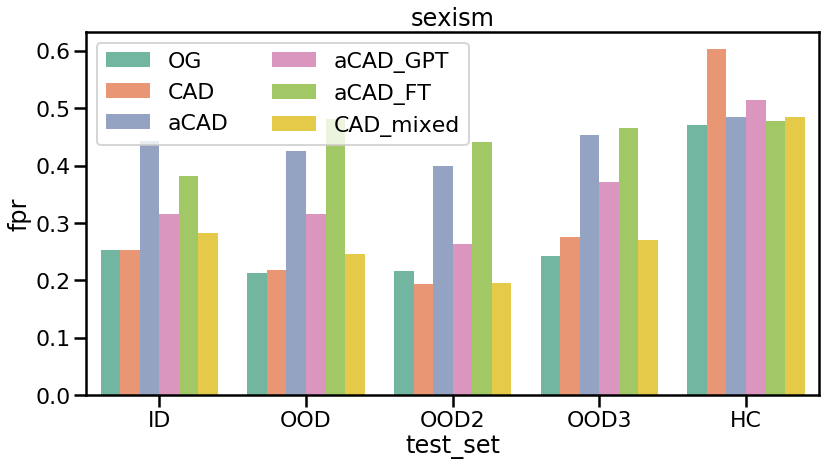

In [64]:
fig, ax = plt.subplots(figsize = (12, 7))
sns.barplot(data = all_results_df, x = 'test_set', y = 'fpr', #join = False,
             hue = 'mode', palette="Set2", # markers = True,#, hue_norm=mpl.colors.LogNorm()
            ax = ax)
title = construct
ax.set_title(title)
plt.legend(ncol=2)
# plt.savefig('../results/figures/svm_%s.pdf' %title)
plt.tight_layout()
plt.show()

### takeaways:

- when we have chatGPT CADs for both sides, it outperforms manual CAD
- otherwsie, one-sided chatGPT CADs are better OOD, but not in HC